In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Get MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Dataset info
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size:     {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing:  {len(test_loader)}")


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.43MB/s]

Training dataset size: 60000
Test dataset size:     10000
Number of batches in training: 938
Number of batches in testing:  157


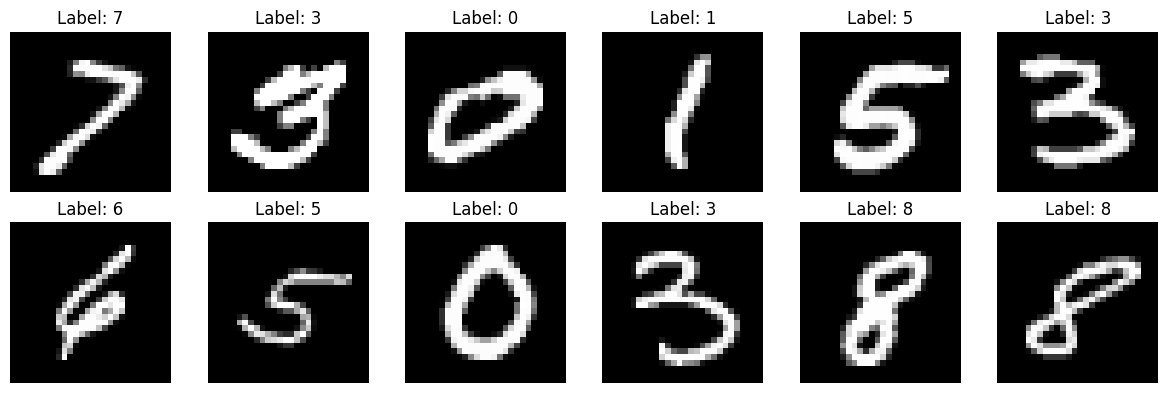

In [3]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super(CNN, self).__init__()

        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.fc_block = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, 1)
        x = self.fc_block(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
num_epochs = 10
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    correct_train, total_train, running_train_loss = 0, 0, 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    correct_test, total_test, running_test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_test_acc = 100 * correct_test / total_test

    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")


Epoch 1/10 [Train]: 100%|██████████| 938/938 [00:19<00:00, 47.50it/s]


Epoch 1/10 | Train Loss: 0.1487, Train Acc: 95.36% | Test Loss: 0.0434, Test Acc: 98.54%


Epoch 2/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.30it/s]


Epoch 2/10 | Train Loss: 0.0637, Train Acc: 97.98% | Test Loss: 0.0390, Test Acc: 98.71%


Epoch 3/10 [Train]: 100%|██████████| 938/938 [00:16<00:00, 58.07it/s]


Epoch 3/10 | Train Loss: 0.0502, Train Acc: 98.37% | Test Loss: 0.0315, Test Acc: 98.98%


Epoch 4/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.01it/s]


Epoch 4/10 | Train Loss: 0.0419, Train Acc: 98.70% | Test Loss: 0.0315, Test Acc: 99.00%


Epoch 5/10 [Train]: 100%|██████████| 938/938 [00:16<00:00, 58.52it/s]


Epoch 5/10 | Train Loss: 0.0371, Train Acc: 98.78% | Test Loss: 0.0313, Test Acc: 99.01%


Epoch 6/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.84it/s]


Epoch 6/10 | Train Loss: 0.0316, Train Acc: 99.00% | Test Loss: 0.0268, Test Acc: 99.06%


Epoch 7/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.43it/s]


Epoch 7/10 | Train Loss: 0.0288, Train Acc: 99.06% | Test Loss: 0.0302, Test Acc: 99.10%


Epoch 8/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 60.34it/s]


Epoch 8/10 | Train Loss: 0.0245, Train Acc: 99.19% | Test Loss: 0.0287, Test Acc: 99.10%


Epoch 9/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 58.75it/s]


Epoch 9/10 | Train Loss: 0.0235, Train Acc: 99.23% | Test Loss: 0.0240, Test Acc: 99.30%


Epoch 10/10 [Train]: 100%|██████████| 938/938 [00:15<00:00, 59.51it/s]


Epoch 10/10 | Train Loss: 0.0215, Train Acc: 99.31% | Test Loss: 0.0250, Test Acc: 99.31%


In [7]:
# Final model evaluation
model.eval()
with torch.no_grad():
    correct, total, running_loss = 0, 0, 0.0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100 * correct / total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0250 | Test Accuracy: 99.31%


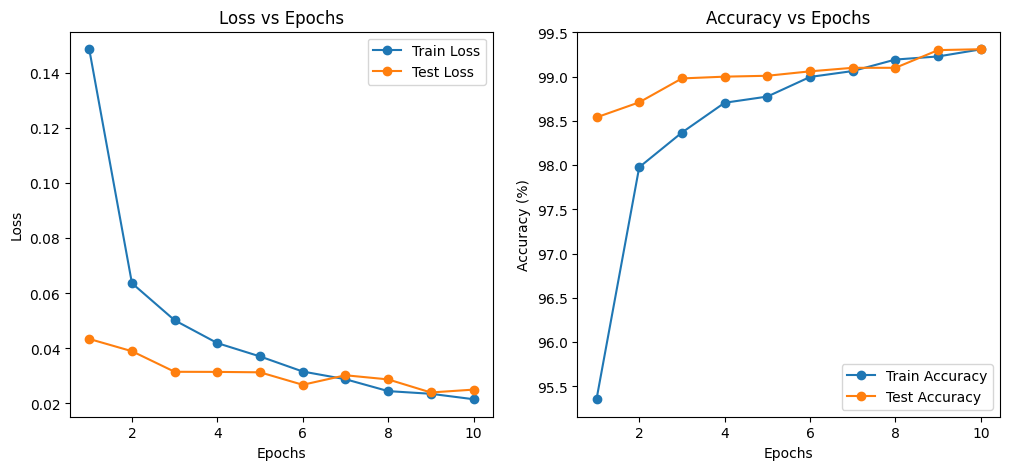

In [8]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, marker='o', label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


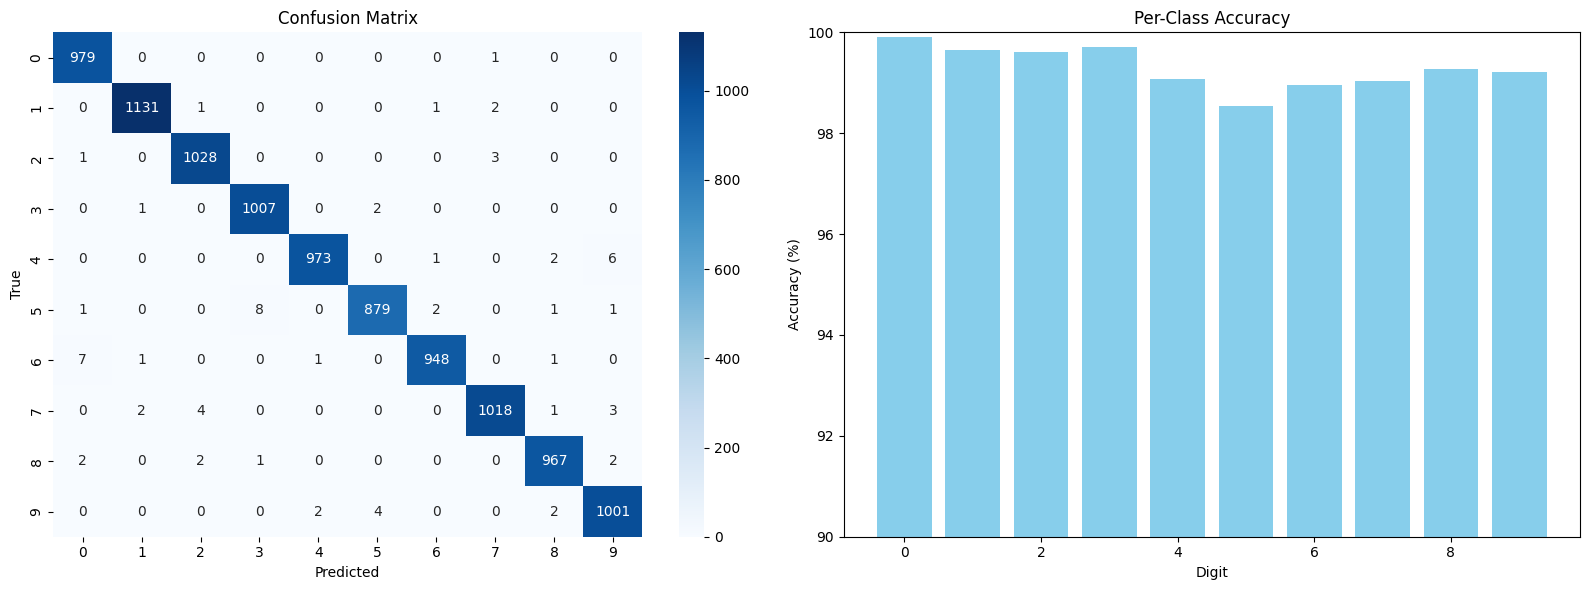

In [9]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_title("Confusion Matrix")

# Per-class accuracy
axes[1].bar(range(10), class_accuracy * 100, color='skyblue')
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Per-Class Accuracy")
axes[1].set_ylim(90, 100)

plt.tight_layout()
plt.show()


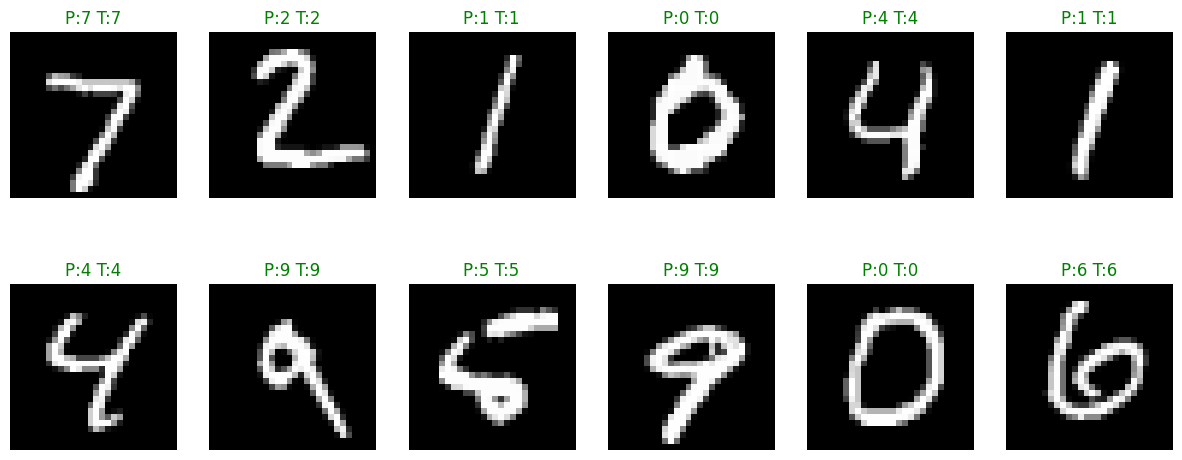

In [10]:
# Show some sample predictions
model.eval()
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
    output = model(example_data.to(device))

pred = output.argmax(dim=1, keepdim=True).cpu().numpy()

plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.imshow(example_data[i][0], cmap='gray')

    color = 'green' if pred[i][0] == example_targets[i].item() else 'red'
    plt.title(f"P:{pred[i][0]} T:{example_targets[i].item()}", color=color)

    plt.axis('off')
plt.show()
